 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Introduction</b></div>

<p style="padding: 10px;color:black;font-size:140%;font-family: Times New Roman, Times, serif;"> Corn and maize are basic ingredients in many regions across the world. The ears can be roasted and eaten as a vegetable right from the cob, or the kernels can be extracted and used to make a range of meals, including cereals and flour. Maize is also a significant source of starch, which can be converted into oils and high-fructose corn syrup. 
All of this makes maize and cornmeal very important ingredients, therefore it's understandable why one would want to keep them free of illnesses like Common Rust, Ray Leaf Spot, and Blight.
These diseases are a major source of concern for maize and corn  growers in Asia, Africa, and the Americas. Plant age, pathogen species, and environment all play a role in symptom expression. The diseases are more common in humid, warm climates.
As a result, early detection of these diseases is critical in order to mitigate the harm.
    The main goal of this project is to use <b>Efficientnet to classify various diseases</b>.
Hope you’ll enjoy &#128515;

In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from collections import defaultdict
from urllib import request
import os
import pandas as pd
import numpy as np
from urllib import request
import cv2
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Dense
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import os
from tensorflow.keras.applications import VGG16
import json
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import tensorflow
import tensorflow as tf
from collections import deque

In [2]:
file_path='../input/corn-or-maize-leaf-disease-dataset/data'


 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Train test validation split</b></div>

<p style="padding: 10px;color:black;font-size:140%;font-family: Times New Roman, Times, serif;"> 
    Here I used split folders libary to split the data into train test and validation given their ratio.

In [3]:
!pip install split_folders

In [4]:
import splitfolders
splitted_folder='../output/corn-or-maize-leaf-disease-dataset/splitted_folder'
def train_test_valid(train_size=0.6,test_size=0.2,val_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)
train_test_valid()

Copying files: 4188 files [00:33, 123.78 files/s]


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_file_path = '../output/corn-or-maize-leaf-disease-dataset/splitted_folder/train'
test_file_path =  '../output/corn-or-maize-leaf-disease-dataset/splitted_folder/test'
val_file_path =  '../output/corn-or-maize-leaf-disease-dataset/splitted_folder/val'

def data_pre_processing(valid_split = 0,input_size = (260, 260),image_color = 'rgb',batch_size = 32,
                        shuffle=True):


    train_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split,fill_mode='nearest',rotation_range=40,horizontal_flip=True)

    validation_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split)

    test_gen=ImageDataGenerator(rescale=1/255.0)

    train_data=train_gen.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    test_data=test_gen.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    valid_data=validation_gen.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    return train_data,test_data,valid_data

train,test,validation=data_pre_processing()

Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Data exploration </b></div>

<p style="padding: 10px;color:black;font-size:140%;font-family: Times New Roman, Times, serif;"> 
    It can be shown that Gray Leaf spot contains less images than the other images, hence it can affect on the results.
    I'll add class weights in order to address this problem.

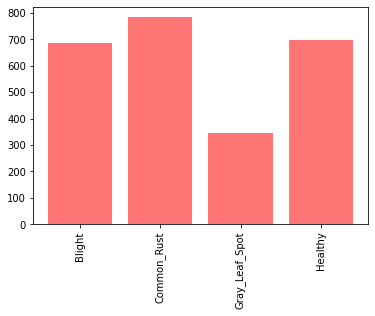

In [6]:
values_counter=Counter(train.classes)
sorted(values_counter.items())
plt.bar(train.class_indices.keys(), values_counter.values(), color=(1, 0.1, 0.1, 0.6))
plt.xticks(rotation=90)
plt.show()

In [7]:
labels=dict()
for label_name,label_num in train.class_indices.items():
        labels[label_num]=label_name

100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


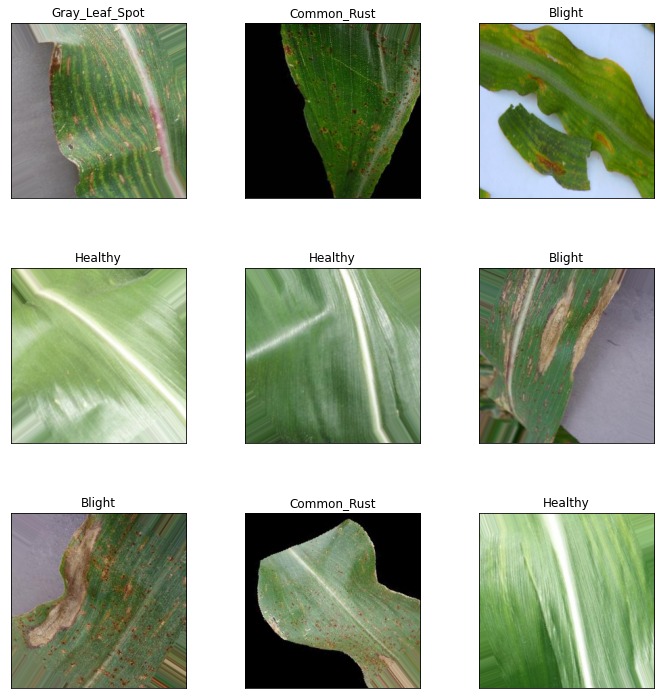

In [8]:
plt.figure(figsize=(10,10))
for i in tqdm(range(9)):
    plt.subplot(3,3,i+1)
    for x_batch,y_batch in train:
        image=x_batch[0]
        argmax=np.argmax(y_batch)
        plt.tight_layout(h_pad=5)
        plt.title(labels[argmax])
        plt.xticks(())
        plt.yticks(())
        plt.imshow(image)
        break

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Create Model </b></div>

<p style="padding: 10px;color:black;font-size:140%;font-family: Times New Roman, Times, serif;"> 
 I used Efficientnet as my pretrained model, with unfreezing all layers since the original data was trained for different task.

In [9]:
!pip install  efficientnet
import efficientnet.tfkeras as enet

     |████████████████████████████████| 50 kB 507 kB/s            


In [10]:
def configure_model():
  inputs_1 = tf.keras.Input(shape=(260, 260, 3))
  mymodel=enet.EfficientNetB2(input_shape = (260, 260, 3), include_top = False, weights = 'imagenet')
  x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(mymodel.output)
  x = tf.keras.layers.Flatten()(x)
  predictors = tf.keras.layers.Dense(4,activation='softmax',name='Predictions')(x)
  final_model = Model(mymodel.input, outputs=predictors)
  return final_model
final_model=configure_model()

2022-02-13 10:05:09.672118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 10:05:09.808343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 10:05:09.809088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 10:05:09.810675: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

31948800/31936256 [==============================] - 1s 0us/step


In [11]:
def model(new_model=final_model,layers_num=1,trainable=False):
    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model
final_model=model(final_model)

In [12]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [13]:
opt=tf.keras.optimizers.Adam(0.0001)
final_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
def callbacks(patience=2):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,min_delta=0.001)
    lr=tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks_list=[checkpoint, early,lr]
    return callbacks_list

In [15]:
callbacks=callbacks()

In [16]:
counter = Counter(train.classes)                          
max_val = float(max(counter.values()))       
class_weights1 = {class_id : max_val/num_images for class_id, num_images in counter.items()}   

In [17]:
hist=final_model.fit(train,epochs=1000,validation_data=(validation),callbacks=callbacks,class_weight=class_weights1)

2022-02-13 10:05:18.854481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2022-02-13 10:05:31.035420: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 77s 742ms/step - loss: 0.6862 - accuracy: 0.8284 - val_loss: 0.5839 - val_accuracy: 0.7751

Epoch 00001: val_loss improved from inf to 0.58392, saving model to my_model.h5
Epoch 2/1000
79/79 [==============================] - 58s 737ms/step - loss: 0.2479 - accuracy: 0.9287 - val_loss: 0.3176 - val_accuracy: 0.8983

Epoch 00002: val_loss improved from 0.58392 to 0.31759, saving model to my_model.h5
Epoch 3/1000
79/79 [==============================] - 58s 730ms/step - loss: 0.1962 - accuracy: 0.9446 - val_loss: 0.2355 - val_accuracy: 0.9115

Epoch 00003: val_loss improved from 0.31759 to 0.23553, saving model to my_model.h5
Epoch 4/1000
79/79 [==============================] - 58s 735ms/step - loss: 0.1449 - accuracy: 0.9574 - val_loss: 0.1600 - val_accuracy: 0.9498

Epoch 00004: val_loss improved from 0.23553 to 0.15997, saving model to my_model.h5
Epoch 5/1000
79/79 [==============================] - 58s 734ms/step - loss: 0.1095 - accuracy: 0

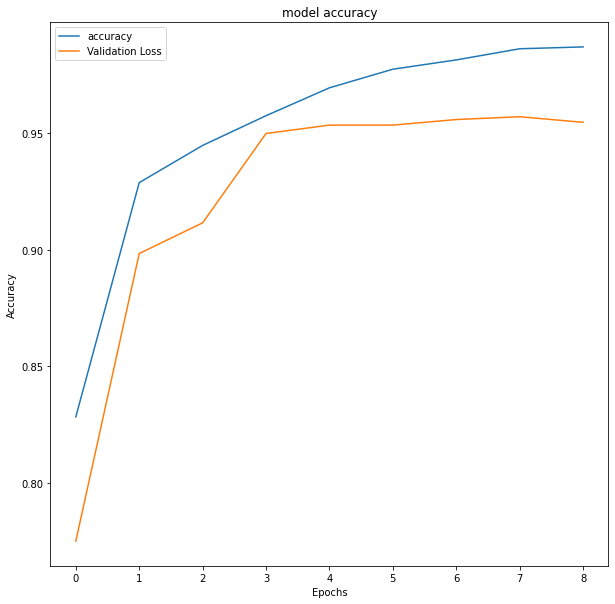

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","Validation Loss"])
plt.show()

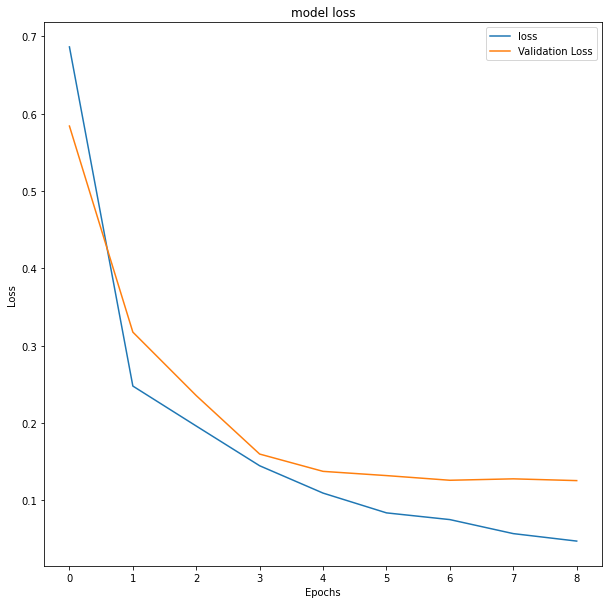

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
final_model=tf.keras.models.load_model('./ResNet50.keras')
final_model.summary()

2024-11-17 09:30:28.893549: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 09:30:28.970765: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 09:30:29.135087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731832229.334745  103904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731832229.387245  103904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 09:30:29.565657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 260, 260,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 260, 260,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 260, 260,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │        512 │ block1a_se_excit

 Total params: 12,080,041 (46.08 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,025,346 (30.61 MB)

In [3]:
y_real=[]
all_pred=[]
count=0
for x,y in test:
  predict=final_model.predict(x)
  
  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

NameError: name 'test' is not defined

In [ ]:
target_names =[]
for key,value in test.class_indices.items():
  target_names.append(f'condition: {key}')
  print(target_names)


In [22]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet2=metrics.confusion_matrix(y_real,all_pred)

In [23]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return


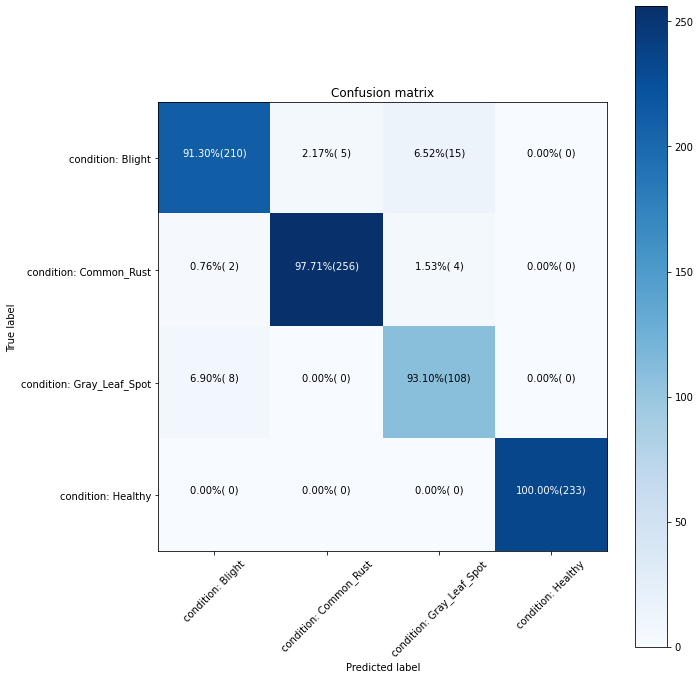

In [24]:
plot_confusion_matrix(conf_efficnet2)

 <div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:300%;
           font-family: Times New Roman, Times, serif;
    letter-spacing:0.5px"><b> Conclusions </b></div>

<p style="padding: 10px;color:black;font-size:140%;font-family: Times New Roman, Times, serif;"> 
From the confusion matrix it can be shown that the results are pretty good with ~95% average accuracy. 
It can be used to detect diseases as early as possible. 